In [6]:
import ast

from collections import Counter

import contractions

from gensim.models import Word2Vec

from itertools import chain

import joblib

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import matplotlib.pyplot as plt

import multiprocessing

from nltk import ngrams
from nltk.probability import FreqDist

import numpy as np

import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_predict

import spacy
import en_core_web_sm

from sentiment_analysis_utils import *

### Definición de semillas para garantizar la reproducibilidad

In [7]:
seed=0
np.random.seed(seed)

# 1. Descarga y exploración del corpus

## Descarga del corpus

In [8]:
reviews_df=pd.read_json('./Cell_Phones_and_Accessories_5.json', lines =  True)

In [9]:
reviews_df.iloc[0]


reviewerID                                           A30TL5EWN6DFXT
asin                                                     120401325X
reviewerName                                              christina
helpful                                                      [0, 0]
reviewText        They look good and stick good! I just don't li...
overall                                                           4
summary                                                  Looks Good
unixReviewTime                                           1400630400
reviewTime                                              05 21, 2014
Name: 0, dtype: object

In [10]:
reviews_df=reviews_df.drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'], axis=1)

In [11]:
def additional_preprocessing(tokens, stopwords, token_min_length):
    
    processed_text=" ".join(
        token for token in tokens if len(token) >= token_min_length and token not in stopwords
    )
    
    return processed_text



## Preprocesamiento preliminar

Comprobams si debemos hacer tratamiento de datos nulos o si no los hay:

In [12]:
reviews_df.isnull().sum()

reviewText    0
overall       0
dtype: int64

Hacemos un preprocesamiento básico inicial para poder explorar los datos:

* Converir a minusculas
* Deshacer contracciones
* Eliminar puntuación
* Mantener solo valores alfabéticos
* Convertir a ASCII
* Eliminar stopwords excepto 'no' y 'not', y lemmatizar

Este preprocesamiento permite unificaar distintas formas de la misma palabra para facilitar la exploración y hacer que en esta tengamos datos más representativos

In [13]:
print("CUDA available:", spacy.prefer_gpu())

CUDA available: True


In [ ]:
spacy.require_gpu()

english_nlp = spacy.load("en_core_web_sm")

reviews_df['processed_tokens'] = reviews_df['reviewText'].apply(lambda x: basic_preprocessing(text=x,language_model=english_nlp))

reviews_df.to_csv("cleaned_reviews.csv", index=False)



Reimportación del dataframe (esta vez con las reviews preprocesadas en lemmas)

In [14]:
reviews_df=pd.read_csv('./cleaned_reviews.csv', sep=',')

# Convert lists imported as strings to lists
reviews_df['processed_tokens'] = reviews_df['processed_tokens'].apply(ast.literal_eval)

Creación de una columna en el dataframe con los tokens unidos usando espacios como separador. Esto será util para posteriores pasos de exploración.

In [15]:
reviews_df['processed_reviews'] = reviews_df['processed_tokens'].apply(lambda tokens: " ".join(tokens))

In [16]:
reviews_df.head(10)

,reviewText,overall,processed_tokens,processed_reviews
0,They look good and stick good! I just don't li...,4,"[look, good, stick, good, not, like, rounded, ...",look good stick good not like rounded shape bu...
1,These stickers work like the review says they ...,5,"[sticker, work, like, review, say, stick, grea...",sticker work like review say stick great stay ...
2,These are awesome and make my phone look so st...,5,"[awesome, phone, look, stylish, far, year, bel...",awesome phone look stylish far year believe ye...
3,Item arrived in great time and was in perfect ...,4,"[item, arrive, great, time, perfect, condition...",item arrive great time perfect condition order...
4,"awesome! stays on, and looks great. can be use...",5,"[awesome, stay, look, great, multiple, apple, ...",awesome stay look great multiple apple product...
5,These make using the home button easy. My daug...,3,"[home, button, easy, daughter, like, purchase,...",home button easy daughter like purchase worth ...
6,Came just as described.. It doesn't come unstu...,5,"[come, describe, not, come, unstuck, cute, peo...",come describe not come unstuck cute people ask...
7,it worked for the first week then it only char...,1,"[work, week, charge, phone, waste, money]",work week charge phone waste money
8,"Good case, solid build. Protects phone all aro...",5,"[good, case, solid, build, protect, phone, goo...",good case solid build protect phone good acces...
9,This is a fantastic case. Very stylish and pro...,5,"[fantastic, case, stylish, protect, phone, eas...",fantastic case stylish protect phone easy acce...


## Tamaño del dataset

In [17]:
print(f"Disponemos de {len(reviews_df)} reviews y calificaciones de productos.")

Disponemos de 194439 reviews y calificaciones de productos.


## Cardinalidad del vocabulario lemmatizado y sin stopwords

In [18]:

all_words = list(chain.from_iterable(reviews_df['processed_tokens']))

In [19]:
word_frequency = Counter(all_words)

print(f'La cardinalidad del vocabulario es {len(word_frequency)}')

La cardinalidad del vocabulario es 65789


## Distribución de reviews por calificación

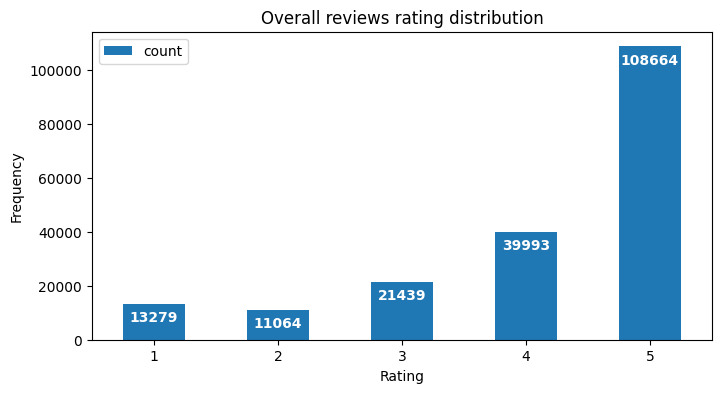

In [20]:
reviews_frequency = pd.DataFrame(reviews_df['overall'].value_counts(sort=False).sort_index())

axes = reviews_frequency.plot(kind='bar', title='Overall reviews rating distribution', figsize=(8, 4))

for p in axes.patches:
    axes.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, -10), 
                textcoords="offset points", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='white',
                fontweight='bold') 

plt.xticks(rotation=0) 
axes.set_ylabel("Frequency")
axes.set_xlabel("Rating")

plt.show()


Vemos que el dataset está muy desbalanceado.

## Número de reviews positivas y negativas

Clasificaremos las calificaciones en 2 categorías: 0 (sentieminto negativo) y 1 (sentiento positivo).

* Sentimiento positivo (le asignaremos valor 1): ⭐⭐⭐⭐ / ⭐⭐⭐⭐⭐
* Sentimiento positivo (le asignaremos valor 0): ⭐ / ⭐⭐ / ⭐⭐⭐


In [21]:
def label_sentiment(row):
    if int(row) > 3:
        return 1
    else:
        return 0
    
reviews_df['sentiment_label'] = reviews_df.apply(lambda row: label_sentiment(row['overall']), axis=1)

In [22]:
reviews_df.head(10)

,reviewText,overall,processed_tokens,processed_reviews,sentiment_label
0,They look good and stick good! I just don't li...,4,"[look, good, stick, good, not, like, rounded, ...",look good stick good not like rounded shape bu...,1
1,These stickers work like the review says they ...,5,"[sticker, work, like, review, say, stick, grea...",sticker work like review say stick great stay ...,1
2,These are awesome and make my phone look so st...,5,"[awesome, phone, look, stylish, far, year, bel...",awesome phone look stylish far year believe ye...,1
3,Item arrived in great time and was in perfect ...,4,"[item, arrive, great, time, perfect, condition...",item arrive great time perfect condition order...,1
4,"awesome! stays on, and looks great. can be use...",5,"[awesome, stay, look, great, multiple, apple, ...",awesome stay look great multiple apple product...,1
5,These make using the home button easy. My daug...,3,"[home, button, easy, daughter, like, purchase,...",home button easy daughter like purchase worth ...,0
6,Came just as described.. It doesn't come unstu...,5,"[come, describe, not, come, unstuck, cute, peo...",come describe not come unstuck cute people ask...,1
7,it worked for the first week then it only char...,1,"[work, week, charge, phone, waste, money]",work week charge phone waste money,0
8,"Good case, solid build. Protects phone all aro...",5,"[good, case, solid, build, protect, phone, goo...",good case solid build protect phone good acces...,1
9,This is a fantastic case. Very stylish and pro...,5,"[fantastic, case, stylish, protect, phone, eas...",fantastic case stylish protect phone easy acce...,1


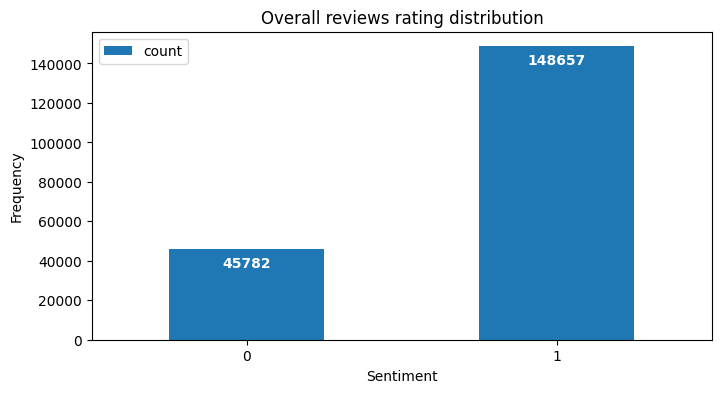

In [23]:
sentiment_frequency = pd.DataFrame(reviews_df['sentiment_label'].value_counts(sort=False).sort_index())

axes = sentiment_frequency.plot(kind='bar', title='Overall reviews rating distribution', figsize=(8, 4))

for p in axes.patches:
    axes.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, -10), 
                textcoords="offset points", 
                ha='center', 
                va='center', 
                fontsize=10, 
                color='white',
                fontweight='bold')

plt.xticks(rotation=0) 
axes.set_ylabel("Frequency")
axes.set_xlabel("Sentiment")

plt.show()

De nuevo, al igual que en la distribución por reviwes vemos que tenemos un dataset muy desbalanceado. Deberemos tenerlo en cuenta, especialmente de cara a en qué métricas del modelo debemos fijarnos más.

El resto de la exploración la haremos únicamente sobre los datos de train para no introducir sesgos derivados de la exploración de datos de test

##  División en test y train

Dejamos un 20% de los ejemplo para test y utilizamos un 80% para train

Estratificamos para asegurar que mantenemos la proporcion de clases en las eqiquetas de sentimiento.

In [24]:
labels = reviews_df['sentiment_label'].values

train_df, test_df = train_test_split(
    reviews_df, 
    test_size = 0.2, 
    shuffle = True, 
    random_state = seed, 
    stratify=labels
)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [25]:
train_df.head()

,reviewText,overall,processed_tokens,processed_reviews,sentiment_label
0,Micro USB is the new standard in cellular devi...,5,"[micro, usb, new, standard, cellular, device, ...",micro usb new standard cellular device bold mi...,1
1,"I only use tech armor on my devices, I keep my...",5,"[use, tech, armor, device, phone, key, pocket,...",use tech armor device phone key pocket not sin...,1
2,First the pieces that hold the case together c...,2,"[piece, hold, case, crack, color, layer, start...",piece hold case crack color layer start peel f...,0
3,The iPhone 5c Wallet Case works well but may n...,4,"[iphone, c, wallet, case, work, not, fit, s, n...",iphone c wallet case work not fit s need look ...,1
4,Excellent ! Super fit looks really good on not...,4,"[excellent, super, fit, look, good, note, thin...",excellent super fit look good note thing make ...,1


## N-grams más frecuentes

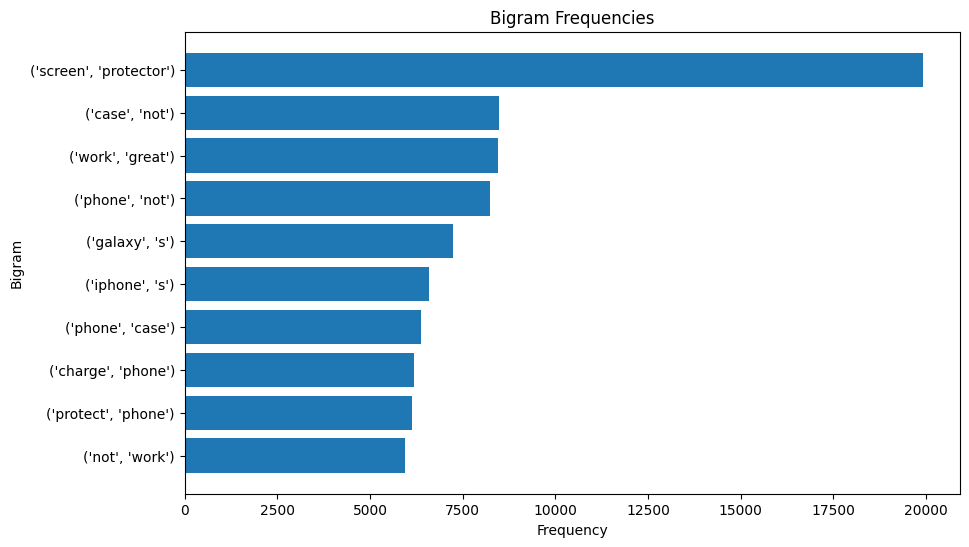

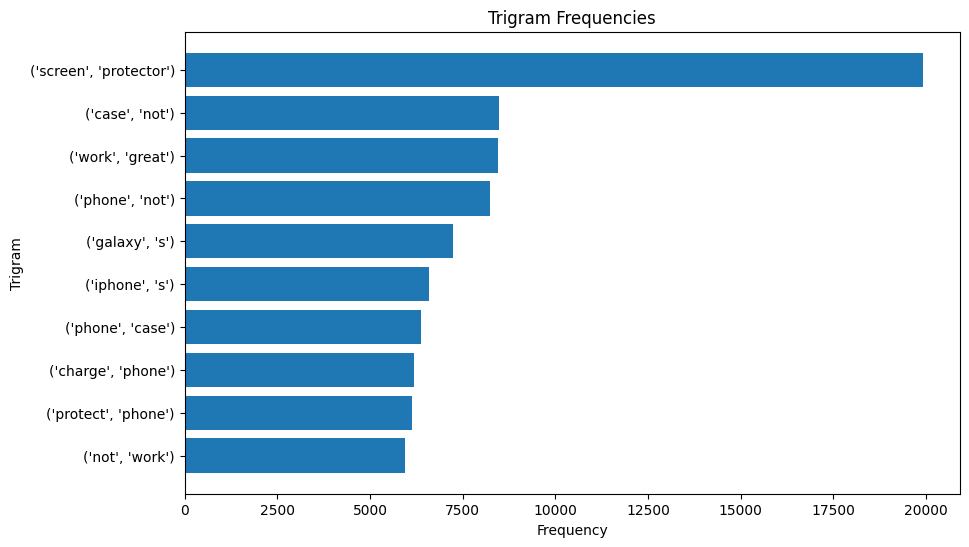

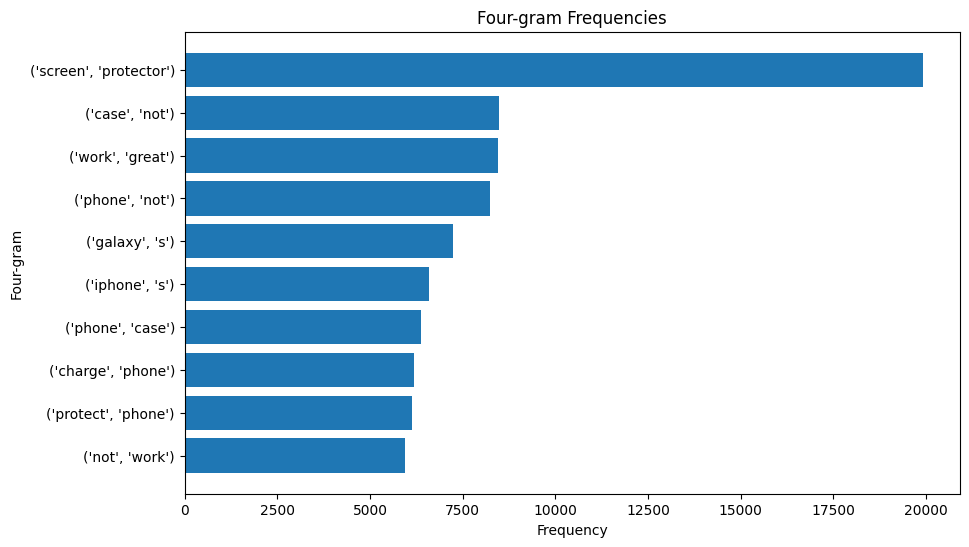

In [26]:
bigrams = []
trigrams = []
fourgrams = []

for tokens in train_df['processed_tokens']:
    bigrams.extend(list(ngrams(tokens, 2)))
    trigrams.extend(list(ngrams(tokens, 2)))
    fourgrams.extend(list(ngrams(tokens, 2)))

bigrams_freq = FreqDist(bigrams)
trigrams_freq = FreqDist(trigrams)
fourgrams_freq = FreqDist(fourgrams)

bigrams_freq_most_common = bigrams_freq.most_common(10)
trigrams_freq_most_common = trigrams_freq.most_common(10)
fourgrams_freq_most_common = fourgrams_freq.most_common(10)

plot_ngram_frequencies(bigrams_freq_most_common, 'Bigram')
plot_ngram_frequencies(trigrams_freq_most_common, 'Trigram')
plot_ngram_frequencies(fourgrams_freq_most_common, 'Four-gram')



Vemos que entre las palabras más frecuentes en los n-gramas la denominación del objeto descrito ("phone", "galaxy", "iphone"...). Posteriormente, haremos un segundo procesamienya eliminando algunas de  palabras ya que no aportan información al sentimiento de la review. Sin embargo, sí mantendremos algunos de los productos frecuentes como, 'case' o 'protector', ya que estos sí podrían formar parte de la review de otro producto que ha sido descrito como frágil, por ejemplo.

También vemos 's' como una palabra frecuente en los n-gramas. Eliminaremos palabras de longitud inferior a 2, ya que no nos aportan información.

 Procesaremos los datos eliminando palabras comunes que simplemente sean

## WordClouds

Negative sentiment WordCloud:


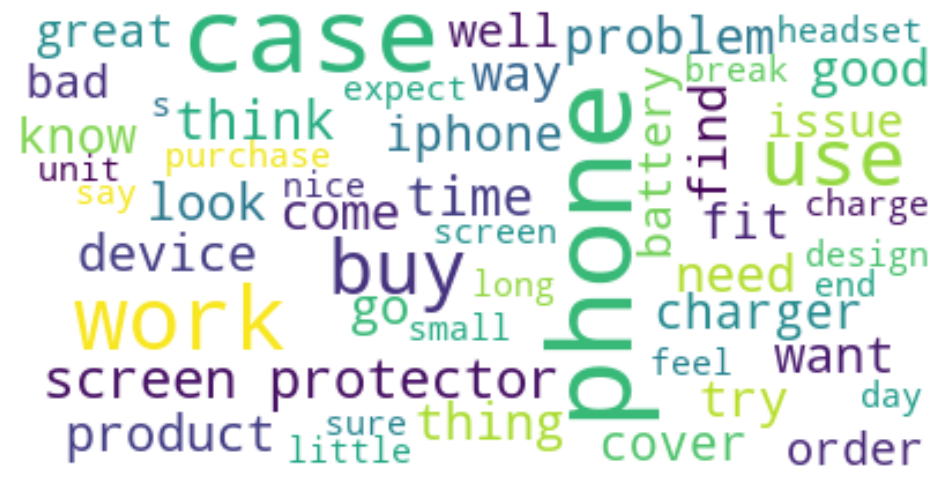

Positive sentiment WordCloud:


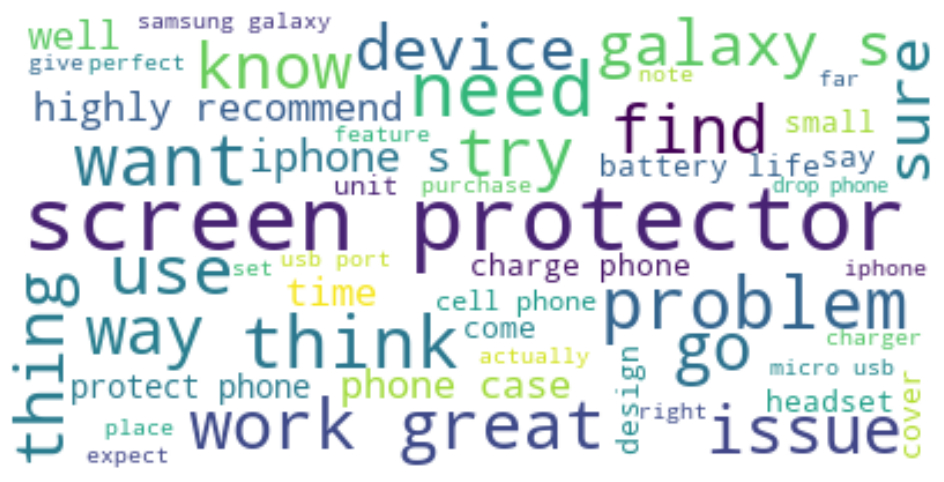

In [27]:
combined_text_negative = " ".join(train_df.loc[train_df['sentiment_label']==0, 'processed_reviews'])
combined_text_positive = " ".join(train_df.loc[train_df['sentiment_label']==1, 'processed_reviews'])

print('Negative sentiment WordCloud:')
plot_word_cloud(combined_text_negative)
print('Positive sentiment WordCloud:')
plot_word_cloud(combined_text_positive)

Vemos que hay palabras que se encuentran en ambos WordClouds. Tiene sentido ya que en su mayoría se refiren al producto descrito.

Además, al igual que en el paso anterior detectamos palabras que son muy comunes pero que solo se refieren al producto en sí o sus componentes y que no aportan información al sentimiento: screen, product, device...

## Visualización 2D de word embeddings

### Definición y entrenamiento del un modelo Word2Vec para obtener palabras similares

Definción del modelo Word2Vec

In [28]:
cores= multiprocessing.cpu_count() 

w2v_model = Word2Vec(
		min_count=5,
		window=2,
		vector_size=100,
		sample=6e-5,
		alpha=0.03,
		min_alpha=0.0007,
		negative=20,
		workers=cores-1
)

INFO - 12:04:01: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2025-02-16T12:04:01.120256', 'gensim': '4.3.3', 'python': '3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}


Construcción del vocabulario

In [29]:

reviews = [row.split() for row in train_df['processed_reviews']]
w2v_model.build_vocab(
		reviews, 
		progress_per=20000
)

print(f'Vocabulario compuesto por {len(w2v_model.wv.key_to_index)} palabras')

INFO - 12:04:02: collecting all words and their counts
INFO - 12:04:02: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:04:02: PROGRESS: at sentence #20000, processed 813345 words, keeping 19210 word types
INFO - 12:04:02: PROGRESS: at sentence #40000, processed 1623831 words, keeping 27552 word types
INFO - 12:04:02: PROGRESS: at sentence #60000, processed 2441574 words, keeping 34098 word types
INFO - 12:04:02: PROGRESS: at sentence #80000, processed 3260338 words, keeping 40282 word types
INFO - 12:04:02: PROGRESS: at sentence #100000, processed 4062235 words, keeping 45382 word types
INFO - 12:04:02: PROGRESS: at sentence #120000, processed 4865504 words, keeping 50204 word types
INFO - 12:04:02: PROGRESS: at sentence #140000, processed 5665290 words, keeping 54548 word types
INFO - 12:04:02: collected 57830 word types from a corpus of 6297389 raw words and 155551 sentences
INFO - 12:04:02: Creating a fresh vocabulary
INFO - 12:04:02: Word2Vec lifecycle 

Vocabulario compuesto por 14438 palabras


Entrenamineto del modelo 

In [30]:
w2v_model.train(
    train_df['processed_tokens'], 
    total_examples = w2v_model.corpus_count,
    epochs = 30,
    report_delay = 1 
)

# Download model
w2v_model.save('./w2v_model.pkl')

INFO - 12:04:02: Word2Vec lifecycle event {'msg': 'training model with 31 workers on 14438 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2 shrink_windows=True', 'datetime': '2025-02-16T12:04:02.851159', 'gensim': '4.3.3', 'python': '3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'train'}
INFO - 12:04:03: EPOCH 0 - PROGRESS: at 82.97% examples, 2100439 words/s, in_qsize 61, out_qsize 3
INFO - 12:04:04: EPOCH 0: training on 6298369 raw words (2540720 effective words) took 1.2s, 2167441 effective words/s
INFO - 12:04:05: EPOCH 1 - PROGRESS: at 82.92% examples, 2107988 words/s, in_qsize 59, out_qsize 2
INFO - 12:04:05: EPOCH 1: training on 6298369 raw words (2544226 effective words) took 1.2s, 2112841 effective words/s
INFO - 12:04:06: EPOCH 2 - PROGRESS: at 83.57% examples, 2121202 words/s, in_qsize 62, out_qsize 1
INFO - 12:04:06: EPOCH 2: training on 62983

### Creación de clusters

Definición de clusters de con palabras similares:

In [31]:
key_words = ['protector','buy','good', 'problem', 'small']
embedding_clusters = []
word_clusters = []

for word in key_words:
    
    embeddings = []
    words = []
    
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        #Extract word numeric value
        embeddings.append(w2v_model.wv[similar_word])
    
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

### Definición y entrenamiento de un modelo TSNE con reducción de la dimensionalidad para visualización 2D

Definición del modelo TSNE

In [32]:
n_components = 2

tsne_model_2d = TSNE(
		perplexity = 20, 
		n_components = n_components, 
		init = 'pca',
		max_iter = 3500,
		random_state = seed
)

Reducción de la dimenisonalidad de los embeddings

In [33]:

embedding_clusters = np.array(embedding_clusters)
initial_words_number, similar_words_number, vector_dimension = embedding_clusters.shape

embeddings_2d = np.array(
		# Reduce la segunda componente de la matriz 2D (vector_dimension) a n_components definido en el modelo
		tsne_model_2d.fit_transform(
				# transforma la matriz 3D en 2D con las dimensiones indicadas
				embedding_clusters.reshape(
						initial_words_number * similar_words_number, 
						vector_dimension 
				)
		)
# Restaurar la estructura 3D volviendo a dividir la primera dimensión en 2
).reshape(
		initial_words_number, 
		similar_words_number, 
		n_components
)

c:\Users\Lucia\.conda\envs\nlpenv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Lucia\.conda\envs\nlpenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Lucia\.conda\envs\nlpenv\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Lucia\.conda\envs\nlpenv\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Lucia\.conda\envs\nlpenv\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executa

### Representación de clusters

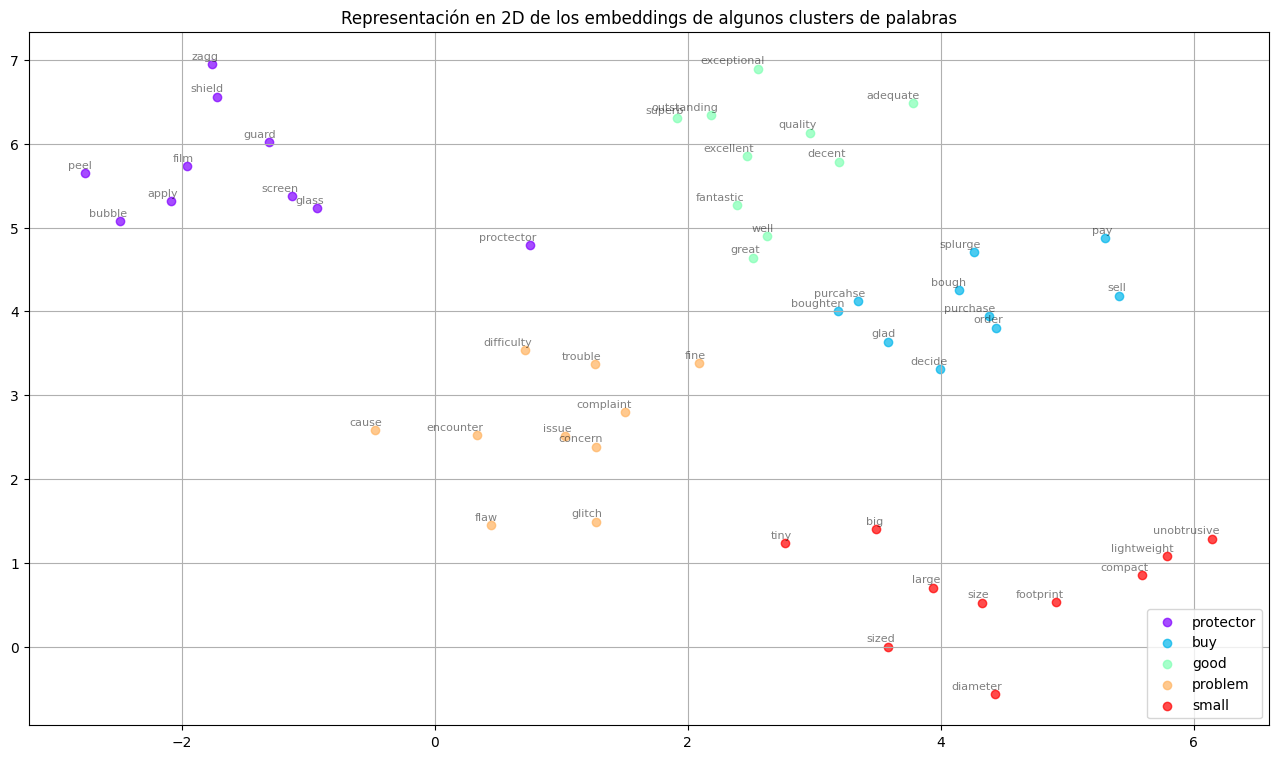

In [34]:
tsne_plot_similar_words(key_words, embeddings_2d, word_clusters)

Vemos que los clusters de las palabras seleccionadas no se mezclan entre sí.

Además, vemos coherencia en las smilitudes encontradas:
* Protector -> palabras relacionadas con protectores de pantalla
* Buy -> palabras relacionadas con compras (tanto por parte de vender como comprar). 'Stumbling' llama la atención, quizá se da a frases del tipo 'stumbling upon a good deal'
* Good -> palabras calificativas que indican satisfacicción con los productos. Vemos ejemplos tanto de calificación suficiento como de calificación sobresaliente.
* Problem -> palabras relacionadas con defectos o resolución de problemas ('fine' tendría solo sentido si hablase de multas o penalizaciones)
* Small -> palabras sobre dimensiones (no necesariamente pequeñas, ya que entre ellas están 'large' o 'big')


De nuevo, tetectamos un par de marcas de productos (de protectores de pantalla) que eliminaremos en el siguiente procesamiento de datos adicional.

# 2. Procesamiento de datos a partir de lo detectado en la exploración

Eliminamos stopwords adicionales como algunas marcas, productos, o componentes de estos.

Definimos nuevos dataframes con los datos procesados diviendo X e y.

In [35]:
stop_words = ['skinomi', 'zagg', 'screen', 'product', 'device', 'cell', 'phone', 
              'iphone', 'galaxy', 'charger', 'headset', 'battery', 'usb', 'samsung']

X_train_df = pd.DataFrame()
X_test_df = pd.DataFrame()
y_train_df = pd.DataFrame()
y_test_df = pd.DataFrame()

X_train_df['reviews'] = (
    train_df['processed_tokens']
        .apply(lambda x: additional_preprocessing(tokens=x,stopwords=stop_words, token_min_length=2))
)

X_test_df['reviews'] = (
    test_df['processed_tokens']
        .apply(lambda x: additional_preprocessing(tokens=x,stopwords=stop_words, token_min_length=2))
)

y_train_df['sentiment_label']=train_df['sentiment_label']
y_test_df['sentiment_label']=test_df['sentiment_label']

X_train_df.to_csv("cleaned_X_train_df.csv", index=False)
X_test_df.to_csv("cleaned_X_test_df.csv", index=False)
y_train_df.to_csv("cleaned_y_train_df.csv", index=False)
y_test_df.to_csv("cleaned_y_test_df.csv", index=False)

El procesamiento que acabamos de realizar junto con el procesamiento preliminar previo equivalen a la siguiente función de procesamiento completa:

In [31]:
def preprocessing(text, language_model, additional_stopwords, token_min_length):
    
    """
    Preprocesses the given text by applying several cleaning steps, lemmatization, and removing additional stopwords.

    The following steps are performed:
        * Converts text to lowercase.
        * Expands contractions.
        * Removes punctuation.
        * Retains only alphabetic characters.
        * Converts text to ASCII.
        * Lemmatizes the tokens and removes stopwords (except "no" and "not").
        * Filters tokens by minimum length and excludes additional stopwords.

    Args:
        text (str): The input text to be processed.
        language_model (spacy.language.Language): A spaCy language model used for lemmatization and token analysis.
        additional_stopwords (list): A list of additional stopwords to be removed from the text.
        token_min_length (int): The minimum length for a token to be retained.

    Returns:
        str: The processed text as a string with lemmatized tokens and no additional stopwords.
    """

    text = text.lower()

    text = contractions.fix(text)

    text = re.sub(r'[^\w\s]', ' ', text)

    text = re.sub("[^A-Za-z']+", ' ', text)

    text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')

    doc = language_model(text)

    tokens = [token.lemma_ for token in doc if not token.is_stop or token.text == "no" or token.text == "not"]
    
    processed_text=" ".join(
        token for token in tokens if len(token) >= token_min_length and token not in additional_stopwords
    )
    
    return processed_text

# 3. Entrenamiento y testeo de modelos de análisis de sentimiento

## Modelos Random Forest

Hacemos un pipeline de entrenamiento de un modelo Random Forest con GridSearchCV y diferentes parámetros tanto del vectorizador usado (TF-IDF).

Se consideran difrentes valores de los siguientes parámetros:

* número máximo de features
* número de elementos de los n-gramas

Se configura en GridSearchCV F1-score como métrica de decisión del mejor modelo, ya que sabemos que están desbalanceada la cantidad de ejemplos de sentimiento positivo y negativo.

In [92]:
pipe = Pipeline([
   ('feature_nlp',TfidfVectorizer(lowercase=True)),
   ('model', RandomForestClassifier())
])

rf_params = {
   'feature_nlp__ngram_range': [(1,2),(2,3)],
   'feature_nlp__max_df': [0.95],
   'feature_nlp__max_features':[3500,1500],
   'model__n_estimators': [50],
   'model__random_state':[seed]
}
   
rf_search = GridSearchCV(
    pipe, 
    rf_params, 
    cv=5,
    verbose=2,
    n_jobs=cores-1,
    scoring='f1'
)

rf_search.fit(X_train_df['reviews'], y_train_df['sentiment_label'])

print(f"GridSearchCV best F1-score: {rf_search.best_score_}")


joblib.dump(rf_search.best_estimator_, 'best_rf_model.pkl')


['best_rf_model.pkl']

## Modelos SVC

Hacemos un pipeline de entrenamiento de un modelo SVC con kernel RBF con GridSearchCV y diferentes parámetros tanto del modelo, como del vectorizador usado (TF-IDF).

Se consideran difrentes valores de los siguientes parámetros:

* parámetro C de regularización del modelo SVC
* número máximo de features
* número de elementos de los n-gramas

Se configura en GridSearchCV F1-score como métrica de decisión del mejor modelo, ya que sabemos que están desbalanceada la cantidad de ejemplos de sentimiento positivo y negativo.

In [ ]:
pipe = Pipeline([
   ('feature_nlp',TfidfVectorizer(lowercase=True)),
   ('model', SVC())
])

svc_params = {
   'feature_nlp__ngram_range': [(1,2),(2,3)],
   'feature_nlp__max_df': [0.95],
   'feature_nlp__max_features':[3500,1500],
   'model__C': [0.1,1],
   'model__kernel': ['rbf'],
   'model__random_state':[seed]
}
   
svc_search = GridSearchCV(
    pipe, 
    svc_params, 
    cv=5,
    verbose=2,
    n_jobs=cores-1,
    scoring='f1'
)

svc_search.fit(X_train_df['reviews'], y_train_df['sentiment_label'])

print(f"GridSearchCV best F1-score: {svc_search.best_score_}")

joblib.dump(svc_search.best_estimator_, 'best_svc_model.pkl')

Vemos las métricas de todos los modelos para ver si el modelo elegido es el que más nos conviene

# 4. Reporte de métricas y conclusiones

Vemos las métricas de validación cruzada de los mejores modelos de Random Forest y SVC.

## Métricas de validación cruzada: mejor modelo Random forest

In [32]:

best_rf_model = joblib.load('best_rf_model.pkl')

rf_y_val_pred = cross_val_predict(best_rf_model, X_train_df['reviews'], y_train_df['sentiment_label'], cv=5)

rf_f1 = f1_score(y_train_df['sentiment_label'], rf_y_val_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y_train_df['sentiment_label'], rf_y_val_pred)
rf_class_report = classification_report(y_train_df['sentiment_label'], rf_y_val_pred)

print(f"\nBest Model F1-score (Cross-Validation): {rf_f1:.4f}")
print("\nConfusion Matrix (Cross-Validation):")
print(rf_conf_matrix)
print("\nClassification Report (Cross-Validation):")
print(rf_class_report)





Best Model F1-score (Cross-Validation): 0.8289

Confusion Matrix (Cross-Validation):
[[ 16940  19686]
 [  4483 114442]]

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.79      0.46      0.58     36626
           1       0.85      0.96      0.90    118925

    accuracy                           0.84    155551
   macro avg       0.82      0.71      0.74    155551
weighted avg       0.84      0.84      0.83    155551



*Log de ejecución de la celda de código anterior:* ----------------------------------

```plaintext
Best Model F1-score (Cross-Validation): 0.8289

Confusion Matrix (Cross-Validation):
[[ 16940  19686]
 [  4483 114442]]

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.79      0.46      0.58     36626
           1       0.85      0.96      0.90    118925

    accuracy                           0.84    155551
   macro avg       0.82      0.71      0.74    155551
weighted avg       0.84      0.84      0.83    155551
```
*Fin del log* -----------------------------------------------------------------------

## Métricas de validación cruzada: mejor modelo SVC

In [38]:

best_svc_model = joblib.load('best_svc_model.pkl')

svc_y_val_pred = cross_val_predict(best_svc_model, X_train_df['reviews'], y_train_df['sentiment_label'], cv=5)

svc_f1 = f1_score(y_train_df['sentiment_label'], svc_y_val_pred, average='weighted')  # Manejo de clases desbalanceadas
svc_conf_matrix = confusion_matrix(y_train_df['sentiment_label'], svc_y_val_pred)
svc_class_report = classification_report(y_train_df['sentiment_label'], svc_y_val_pred)


print(f"\nBest Model F1-score (Cross-Validation): {svc_f1:.4f}")
print("\nConfusion Matrix (Cross-Validation):")
print(svc_conf_matrix)
print("\nClassification Report (Cross-Validation):")
print(svc_class_report)



Best Model F1-score (Cross-Validation): 0.8628

Confusion Matrix (Cross-Validation):
[[ 21837  14789]
 [  5449 113476]]

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.80      0.60      0.68     36626
           1       0.88      0.95      0.92    118925

    accuracy                           0.87    155551
   macro avg       0.84      0.78      0.80    155551
weighted avg       0.86      0.87      0.86    155551



*Log de ejecución de la celda de código anterior:* ----------------------------------

Best Model F1-score (Cross-Validation): 0.8628

```plaintext
Confusion Matrix (Cross-Validation):
[[ 21837  14789]
 [  5449 113476]]

Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           0       0.80      0.60      0.68     36626
           1       0.88      0.95      0.92    118925

    accuracy                           0.87    155551
   macro avg       0.84      0.78      0.80    155551
weighted avg       0.86      0.87      0.86    155551

```
*Fin del log* -----------------------------------------------------------------------


No prestaremos especial atención a la métrica de accuracy ya que esta métrica no es adecuada para evaluar modelos entrenados con dataasets desbalanceados (como es el caso).

Por contrario, la métrica que hemos elegido (F1-Score) en GridSearch es una métrica adecuada para datasets desbalanceados. Conseguir un F1-score alto indicaría que tenemos un buen equilibrio entre precisión en Recall.

Vemos que, aunque exista un considerable margen de mejora, ambos han conseguido un buen F1-score.

En cuanto al Recall, el de la clase 0 del modelo Random Forest es bastante bajo. El de SVC lo supera por un margen significativo, mientras que solo presenta un Recall de la clase positiva un 1% peor. La razón de que el modelo Fandom Forest haya presentado un Recall tan bajo en la clase 1 la podemos ver en la matriz de confusión: el modelo confundió muchos casos de sentimiento negativo.

## Elección de un modelo

Nuestro modelo pretende un equilibrio entre una adecuada entre la calidad de la clasificación pasitiva y negativa:

* Los casos positivos nos permiten presentarle al cliente resultados más atractivos de los que sea más susceptible de comprarlos. Además estos pueden ser tomados como ejemplo para el desarrollo de nuevos productos.
* Los casos negativos nos permiten analizar las oportunidades de mejora en la satisfacción del cliente.

Teniendo eso en cuenta, elegiremos el modelo SVC como modelo más adecuado, ya que mantiene un mejor equilibrio en cómo de bien clasifica los casos negativos y los positivos.

In [36]:
best_model = joblib.load('best_svc_model.pkl')

## Evaluación en test del modelo elegido y conclusiones

In [37]:
y_test_pred = best_model.predict(X_test_df['reviews'])

f1 = f1_score(y_test_df['sentiment_label'], y_test_pred, average='weighted') 
conf_matrix = confusion_matrix(y_test_df['sentiment_label'], y_test_pred)
class_report = classification_report(y_test_df['sentiment_label'], y_test_pred)

print(f"\nBest Model F1-score (Test Set): {f1:.4f}")
print("\nConfusion Matrix (Test Set):")
print(conf_matrix)
print("\nClassification Report (Test Set):")
print(class_report)



Best Model F1-score (Test Set): 0.8663

Confusion Matrix (Test Set):
[[ 5560  3596]
 [ 1346 28386]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.61      0.69      9156
           1       0.89      0.95      0.92     29732

    accuracy                           0.87     38888
   macro avg       0.85      0.78      0.81     38888
weighted avg       0.87      0.87      0.87     38888



*Log de ejecución de la celda de código anterior:* ----------------------------------

Best Model F1-score (Cross-Validation): 0.8628

```plaintext
Best Model F1-score (Test Set): 0.8663

Confusion Matrix (Test Set):
[[ 5560  3596]
 [ 1346 28386]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.81      0.61      0.69      9156
           1       0.89      0.95      0.92     29732

    accuracy                           0.87     38888
   macro avg       0.85      0.78      0.81     38888
weighted avg       0.87      0.87      0.87     38888

```
*Fin del log* -----------------------------------------------------------------------


Los valores obtenidos en test han sido muy similares a los de validación. 

Podemos concluir que tenemos un buen modelo , pero que presenta un considerable margen de mejora, especialmente en la clase negativa. Dado que esta era clase con meno número de muestras, de cara a posibles mejoras podrían realizarse técnicas de balanceo de datos que ayuden a mitigar el desbalanceo que provoca que nuestro modelo aprenda más de la clase positiva.